### Сравним частотный и Байесовский методы оценки АБ тестов, оценим проблему подглядывания. 



#### Проверяем одностороннюю гипотезу о равенстве средних для данных из распределения Бернулли. 

#### Ход работ:
1. Определяем необходимый размер выборки при заданных параметрах
2. Прогоняем тест, проверяем, что допустимые значения получения ошибок 1 и 2 рода совпадают с $α$ и $β$ 
3. Симулируем эксперимент, при котором после накопления 100 наблюдений начинаем подглядывать и снимать текущие рез-ты
4. Оцениваем новую вероятность получения ошибок  

Проводим данные действия поочередно с:  
1) Частотным методом,  
2) Байесовским анализом параметров (pB > pA),  
3) Байесовским сравнением гипотез (BF)


Зафиксируем параметры эксперимента и оценим необходимый размер выборки по формуле:
$$
n > \frac{\left[ \Phi^{-1}(1 - \alpha) + \Phi^{-1}(1 - \beta) \right]^2 \left( \sigma_X^2 + \sigma_Y^2 \right)}{\varepsilon^2}
$$

In [ ]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns

alpha, beta = 0.05, 0.2    # вероятности ошибок
p1 = 0.05                   # исходная конверсия
effect = 0.01               # эффект
p2 = p1 + effect           # конверсия с эффектом

sum_var = p1 * (1 - p1) + p2 * (1 - p2)
t_alpha = stats.norm.ppf(1 - alpha, loc=0, scale=1)
t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
size = int(np.ceil((t_alpha + t_beta) ** 2 * sum_var / effect ** 2))
print(size)

#### Частотный подход.
В частотном подходе мы не проверяем истинность нулевой гипотезы напрямую. 
Мы смотрим на то, насколько наблюдаемые данные с ней согласуютя, и если вероятность получения таких или более экстремальных данных (pvalue)
ниже порогового значения, мы отбрасываем H₀.

Реализуем функцию, проверяющую гипотезу частотным подходом:

In [513]:
def frequentist_test(group_a, len_a, group_b, len_b, alpha=0.05):
    pvalue = proportions_ztest(
        [group_a, group_b], [len_a, len_b], alternative="smaller"
    )[1]
    decision = int(pvalue<alpha)
    return pvalue, decision

group_a = np.random.binomial(size, p1)
group_b = np.random.binomial(size, p2)
pvalue = frequentist_test(group_a, size, group_b, size)[0]
print(f" group_a:{group_a}, group_b:{group_b}, p_value: {pvalue:0.3f}")

 group_a:308, group_b:375, p_value: 0.004


Проведем симуляцию из 10000 АА и АБ тестов, сравним доли ложноположительных срабатываний и мощность теста с заданными $α$ и $β$:

False positive rate: 0.051
Statistical power:0.804


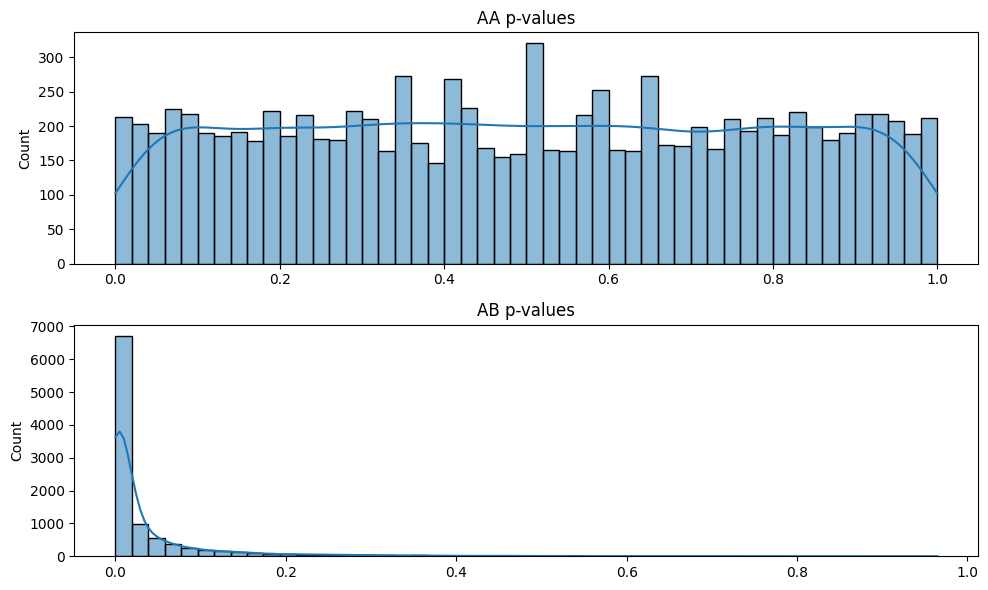

In [514]:
freq = defaultdict(list)
for _ in range(10000):
       group_a, group_b = np.random.binomial(size, p1, 2)
       group_b_effect = np.random.binomial(size, p2)
       freq['AA_freq'].append(frequentist_test(group_a, size, group_b, size)[0])
       freq['AB_freq'].append(frequentist_test(group_a, size, group_b_effect, size)[0])
AA = np.array(freq['AA_freq'])
AB = np.array(freq['AB_freq'])
false_pos_f    = np.mean(AA < alpha)   # эмпирическая ошибка I рода
stat_power_f   = np.mean(AB < alpha)   # эмпирическая мощность

print(f"False positive rate: {false_pos_f:.3f}")
print(f"Statistical power:{stat_power_f:.3f}")

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)  
sns.histplot(AA, bins=50, kde=True)
plt.title("AA p-values")
plt.subplot(2, 1, 2)  
sns.histplot(AB, bins=50, kde=True)
plt.title("AB p-values")
plt.tight_layout()  
plt.show()

Значения совпадают, тест работает корректно

Теперь реализуем функцию, которая имитирует подлглядывание:
После накопления по 100 наблюдений в выборках, будем добавлять к ним по 100 наблюдений и сравнивать их частотным подходом.
Как только тест прокрашивается, останавливаем эксперимент и отклоняем H₀. 
Выведем отдельно размеры выборок, на которых тест прокрасился
Прогоним тест на выборках без эффекта и оценим долю ложноположительных срабатываний:

In [519]:
batch_size = 100
positives_freq = 0
freq['sample_size'] = []
for j in range (10000):
        group_a = np.random.binomial(1, p1, size)
        group_b = np.random.binomial(1, p1, size)
        for i in range(100, 6425, batch_size):
            batch_a = np.sum(group_a[0:i+batch_size])
            batch_b = np.sum(group_b[0:i+batch_size])
            decision = frequentist_test(batch_a, i+batch_size, batch_b, i+batch_size)[1]
            if decision ==1:
                positives_freq +=1
                freq['sample_size'].append(i+batch_size)
                break
            

false positives share: 0.2666


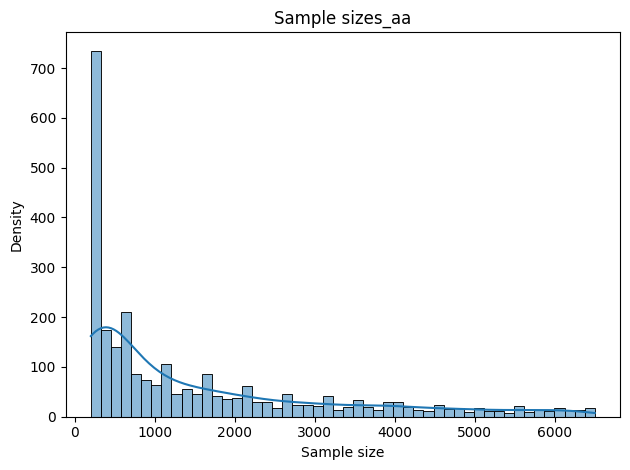

In [520]:
print(f"false positives share: {positives_freq/10000}")
sns.histplot(freq['sample_size'], bins=50, kde=True)
plt.title("Sample sizes_aa")
plt.xlabel("Sample size")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

Как мы видим, доля ложноположительных срабатываний заметно больше альфы - более чем в четверти случаев тест прокрасился,
хотя эффекта нет. Случилось так потому, что $α$ = 0.05 означает, что в каждом измерении шанс получить ложноположительный
результат составляет 5%. Поскольку мы проводим множество последовательных измерений, ошибка первого рода копится. 
Более того, существующие способы корректировки групповой вероятности ошибки 1 рода, такие как метод Бонферрони и Холма, 
применяемые при множественном тестировании, не применимы, т.к. наши наблюдения не являются независимыми.
**Вывод - частотный метод подглядывать не позволяет.**


### Байесовский анализ параметров (pB > pA)

Здесь, как и в частотном подходе, мы не проверяем истинность $ H_0 $ напрямую.  
Мы предполагаем, что $ H_1 $ верна и конверсии групп действительно могут отличаться.

На первом этапе задаётся априорное распределение для вероятностей конверсии в каждой группе — например,  
$$( p_A, p_B \sim \mathrm{Beta}(\alpha, \beta) )$$
Это распределение отражает наши предварительные представления о возможных значениях конверсий (до эксперимента).  
Если предварительные убеждения у нас отсутствуют, мы задаем неинформативный приор
$$( \mathrm{Beta}(1, 1) )$$

Далее мы корректируем приор с учетом наблюдаемых данных, и мы получаем апостериорное распределение  
$$( P(p_A, p_B \mid \text{data}) )$$
Это распределение отражает уже обновлённые убеждения о вероятностях конверсии, скомбинировав априорные ожидания и фактические результаты эксперимента.

Из этого совместного апостериорного распределения вычисляем вероятность того, что  
$$( P(p_B > p_A \mid \text{data}) )$$ — то есть насколько правдоподобно, что группа B конвертирует лучше, чем A, при данных наблюдениях.

Если эта апостериорная вероятность превышает заранее установленный порог (например, 0.95),  
мы считаем, что данные дают достаточно уверенности, чтобы заключить, что B действительно лучше A.

Важно отметить, что порог  0.95  — это не то же самое, что p-value = 0.05,  
так как концептуально это разные вещи (хоть и на практике похожие).

Реализуем функцию `bayesian_prob`, которая оценивает вероятность того, что конверсия группы **B** выше, чем **A**,  
используя Байесовский подход с Beta-распределением.

Априор:
$$
p_A, p_B \sim \mathrm{Beta}(\text{prior}_a[0], \text{prior}_a[1])
$$

Апостериор:
$$
p_A \mid \text{data} \sim \mathrm{Beta}(\text{prior}_a[0] + \text{group}_a,\; \text{prior}_a[1] + \text{len}_a - \text{group}_a)
$$
$$
p_B \mid \text{data} \sim \mathrm{Beta}(\text{prior}_b[0] + \text{group}_b,\; \text{prior}_b[1] + \text{len}_b - \text{group}_b)
$$

Вычисляем вероятность превосходства:
$$
P(p_B > p_A \mid \text{data}) \approx \frac{1}{n} \sum_{i=1}^{n} I(p_B^{(i)} > p_A^{(i)})
$$

Решение принимается, если  
$$
P(p_B > p_A \mid \text{data}) > 1 - \alpha
$$


In [375]:
def bayesian_prob(
        group_a, len_a, group_b, len_b, prior_a, prior_b,
        n=10000, alpha=0.05
):
    posterior_a = [prior_a[0] + group_a, prior_a[1] + len_a - group_a]
    posterior_b = [prior_b[0] + group_b, prior_b[1] + len_b - group_b]
    values_a = np.random.beta(*posterior_a, size=n)
    values_b = np.random.beta(*posterior_b, size=n)
    prob_b_more_a = (values_b > values_a).mean()
    decision = int(prob_b_more_a > 1 - alpha)
    return prob_b_more_a, decision
    
group_a = np.random.binomial(size, p1)
group_b = np.random.binomial(size, p2)
prior_a = [1, 1]
prior_b = [1, 1]

prob, decision = bayesian_prob(group_a, size, group_b, size, prior_a, prior_b)
print(f'group_a={group_a}, group_b={group_b}, prob_b_more_a={prob:0.3f}, decision={decision}')

group_a=323, group_b=353, prob_b_more_a=0.882, decision=0


False positive rate: 0.052
Statistical power:0.805


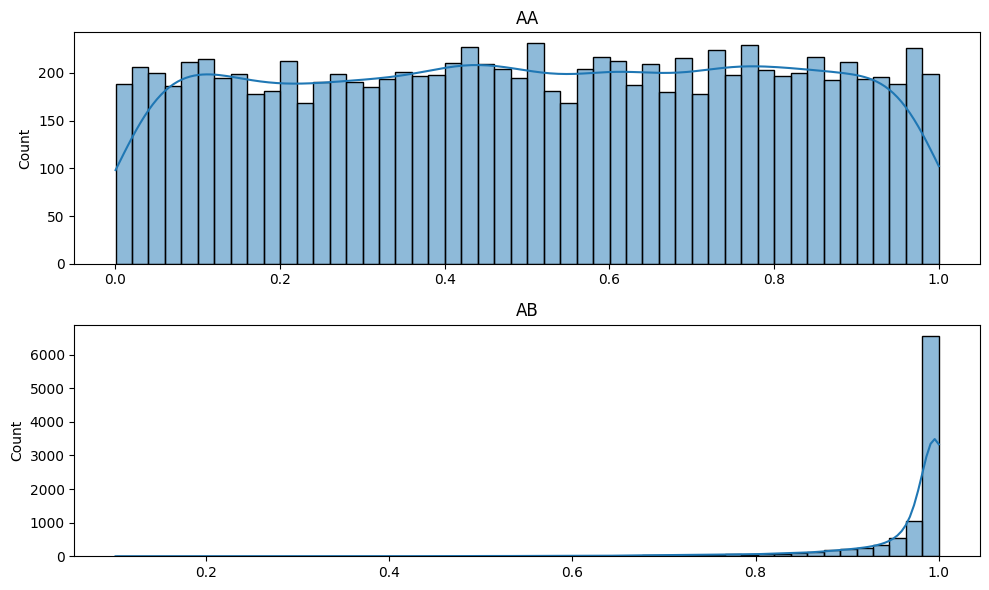

In [521]:
probs = defaultdict(list)
for _ in range(10000):
       group_a, group_b = np.random.binomial(size, p1, 2)
       group_b_effect = np.random.binomial(size, p2)
       probs['AA-bayes_prob'].append(bayesian_test(group_a, size, group_b, size, prior_a, prior_b)[0])       
       probs['AB-bayes_prob'].append(bayesian_test(group_a, size, group_b_effect, size, prior_a, prior_b)[0]) 
       
AA_prob = np.array(probs['AA-bayes_prob'])
AB_prob = np.array(probs['AB-bayes_prob'])
false_pos_prob = np.mean(AA_prob > 1-alpha)   # эмпирическая ошибка I рода
stat_power_prob  = np.mean(AB_prob > 1-alpha)  # эмпирическая мощность

print(f"False positive rate: {false_pos_prob:.3f}")
print(f"Statistical power:{stat_power_prob:.3f}")


plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)  
sns.histplot(AA_prob, bins=50, kde=True)
plt.title("AA")
plt.subplot(2, 1, 2)  
sns.histplot(AB_prob, bins=50, kde=True)
plt.title("AB")
plt.tight_layout()  
plt.show()

Значения совпадают, тест работает корректно

Имитируем подглядывание известным способом:

In [522]:
batch_size = 100
positives_bayes = 0

for j in range (10000):
        group_a = np.random.binomial(1, p1, size)
        group_b = np.random.binomial(1, p1, size)
        for i in range(100, 6425, batch_size):
            batch_a = np.sum(group_a[0:i+batch_size])
            batch_b = np.sum(group_b[0:i+batch_size])
            decision = bayesian_test(batch_a, i+batch_size, batch_b, i+batch_size, prior_a, prior_b)[1]
            if decision ==1:
                positives_bayes +=1
                probs['sample_size'].append(i+batch_size)
                break
            

false positives share: 0.2624


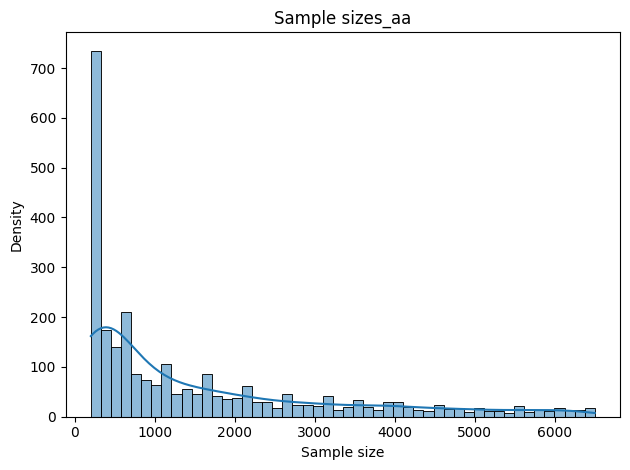

In [523]:
print(f"false positives share: {positives_bayes/10000}")
sns.histplot(freq['sample_size'], bins=50, kde=True)
plt.title("Sample sizes_aa")
plt.xlabel("Sample size")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

Результаты как две капли воды схожи с частотным способом. 
Выводы, соотвественно, те же - **подглядывать нельзя, ошибка 1 рода не контролируется**

### Байесовское сравнение гипотез (BF)

Байесовское сравнение гипотез радикально отличается от двух предыдущих методов. Здесь мы непосредственно оцениваем истинность самой $ H_0 $ напрямую, а не косвенно.  
Метод основан на вычислении **Bayes Factor (BF)** — отношения правдоподобий наблюдаемых данных при двух конкурирующих моделях (гипотезах).  
BF показывает, насколько сильнее данные поддерживают одну модель по сравнению с другой:

$$
BF_{10} = \frac{P(\text{данные} \mid H_1)}{P(\text{данные} \mid H_0)}
$$

Здесь $( H_0 )$ — нулевая модель (наблюдения двух групп получены из одного распределения → отличий в группах нет),  
а $( H_1 )$ — альтернативная (у каждой из групп своя вероятностная модель → конверсии разные).

Значения $ BF > 1 $ указывают на поддержку альтернативной модели,  
а $ BF < 1 $ — на поддержку нулевой гипотезы.

Теория утверждает, что метод устойчив к подглядываниям, поскольку $ BF $ — это аккумулированное отношение правдоподобий,  
которое учитывает весь путь данных, поэтому результаты анализа не зависят от момента остановки эксперимента.  
Если в двух предыдущих методах статистический шум на малых выборках триггерит ложные срабатывания,  
то **Bayes Factor** не реагирует на случайные флуктуации данных, так как каждое новое наблюдение лишь постепенно обновляет соотношение правдоподобий моделей.  

Вместо резких скачков, как при пороговых критериях, $ BF $ накапливает свидетельства в пользу одной из гипотез,  
оставаясь нейтральным при шумовых колебаниях и уверенно возрастая только при устойчивом различии между группами.

---

Идем по стандартному сценарию, реализуем функцию `bayesian_bf`, которая вычисляет **Байесовский фактор (BF₁₀)** для сравнения гипотез:

- $ H_0 $: группы имеют общую вероятность успеха  
- $ H_1 $: каждая группа имеет свою вероятность успеха


Правдоподобие данных под каждой гипотезой выражается через Beta-функцию:

$$
\log m_1 =
\big[\ln B(a_A + x_A,\, b_A + n_A - x_A) - \ln B(a_A,\, b_A)\big] +
\big[\ln B(a_B + x_B,\, b_B + n_B - x_B) - \ln B(a_B,\, b_B)\big]
$$

$$
\log m_0 =
\ln B(a_0 + x_A + x_B,\, b_0 + n_A + n_B - (x_A + x_B)) - \ln B(a_0,\, b_0)
$$

Байесовский фактор:
$$
BF_{10} = \exp(\log m_1 - \log m_0)
$$

Для учёта направления эффекта вероятность того, что \( p_B > p_A \), оценивается как:
$$
P(p_B > p_A \mid \text{data}) \approx \frac{1}{N} \sum_{i=1}^{N} I(p_B^{(i)} > p_A^{(i)})
$$

И итоговый скорректированный Байесовский фактор:
$$
BF_{10}^\ast = BF_{10} \times 2 \times P(p_B > p_A)
$$



In [ ]:
from scipy.special import betaln  

def bayesian_bf(
    group_a, len_a, group_b, len_b,
    prior_a=(1, 1), prior_b=(1, 1), prior_common=None,
):
    aA, bA = prior_a
    aB, bB = prior_b
    if prior_common is None:
        a0, b0 = prior_a
    else:
        a0, b0 = prior_common

    xA, nA = int(group_a), int(len_a)
    xB, nB = int(group_b), int(len_b)

    # log m1 = [ln B(aA+xA, bA+nA-xA) - ln B(aA,bA)] + [то же для B]
    log_m1 = (betaln(aA + xA, bA + nA - xA) - betaln(aA, bA)
              + betaln(aB + xB, bB + nB - xB) - betaln(aB, bB))

    # log m0 = ln B(a0+xA+xB, b0+nA+nB - (xA+xB)) - ln B(a0,b0)
    log_m0 = (betaln(a0 + xA + xB, b0 + (nA + nB) - (xA + xB))
              - betaln(a0, b0))

    log_bf10 = log_m1 - log_m0
    bf10 = float(np.exp(log_bf10))

    post_a = (aA + xA, bA + nA - xA)
    post_b = (aB + xB, bB + nB - xB)
    va = np.random.beta(*post_a, size=10000)
    vb = np.random.beta(*post_b, size=10000)
    post_prob = (vb > va).mean()         
    bf10 *= 2 * post_prob               
  
    return bf10




group_a = np.random.binomial(size, p1)
group_b = np.random.binomial(size, p2)
prior_a = [1, 1]
prior_b = [1, 1]

bf = bayesian_bf(group_a, size, group_b, size, prior_a, prior_b)
print(f'group_a={group_a}, group_b={group_b}, BF={bf:0.3f}')

Запустим симуляцию, оценим ошибки 1 и 2 рода:

False positive rate: 0.001
Statistical power:0.803


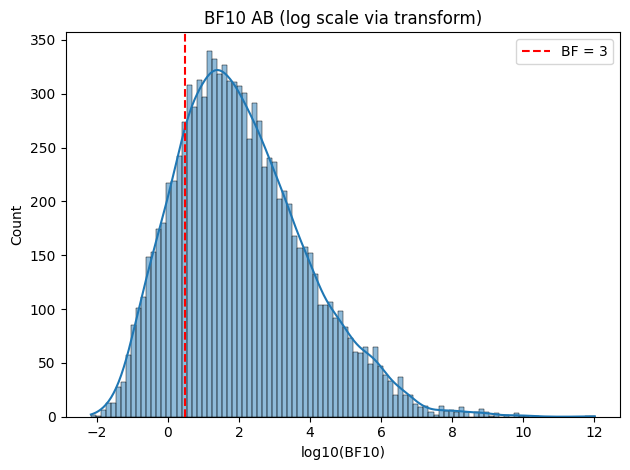

In [530]:
size_bf = round(size*2.8)
probs_bf = defaultdict(list)
for _ in range(10000):
       group_a, group_b = np.random.binomial(size_bf, p1, 2)
       group_b_effect = np.random.binomial(size_bf, p2)
       probs_bf['AA_bayes_bf'].append(bayesian_bf(group_a, size_bf, group_b, size_bf, prior_a, prior_b))       
       probs_bf['AB_bayes_bf'].append(bayesian_bf(group_a, size_bf, group_b_effect, size_bf, prior_a, prior_b)) 
       
AA_bayes_bf = np.array(probs_bf['AA_bayes_bf'])
AB_bayes_bf = np.array(probs_bf['AB_bayes_bf'])
false_pos_bf = np.mean(AA_bayes_bf>3)   
stat_power_bf = np.mean(AB_bayes_bf>3) 

print(f"False positive rate: {false_pos_bf:.3f}")
print(f"Statistical power:{stat_power_bf:.3f}")

sns.histplot(np.log10(AB_bayes_bf), bins=100, kde=True)
plt.axvline(np.log10(3), ls='--', color='red', label='BF = 3')
plt.xlabel('log10(BF10)')
plt.title('BF10 AB (log scale via transform)')
plt.legend()
plt.tight_layout()
plt.show()



#### Наблюдения
1. Для того, чтобы достичь чувствительности в 80%, размер выборки должен быть в 2,8 раза больше - метод более строгий
2. Ошибка 1 рода при этом равна 0.001 - такого соотношения между ошибками 1 и 2 рода мы еще не видели
3. Поскольку нельзя провести параллель между критериями тестов, кардинально отличающимися концептуально, мы не можем перевести
 альфу 0.05 в какой-то конкретный BF. Учитывая полученные результаты, остановимся на BF=3 и будем считать что уровень достоверности в таком случае
 сравним с предыдущими тестами
4. На графике с лог-шкалой мы видим, что 80% наблюдений превышают порог в BF=3

**Настало время истины, так можно все таки подглядывать или нет?  Нет сил терпеть эту ингригу, давайте проверим:**

In [529]:
batch_size = 300
positives_bf_aa = 0

for j in range (10000):
        group_a = np.random.binomial(1, p1, size_bf)
        group_b = np.random.binomial(1, p1, size_bf)
        for i in range(100, size_bf, batch_size):
            batch_a = np.sum(group_a[0:i+batch_size])
            batch_b = np.sum(group_b[0:i+batch_size])
            bf = bayesian_bf(batch_a, i+batch_size, batch_b, i+batch_size, prior_a, prior_b)
            if bf > 3:
                positives_bf_aa +=1
                probs_bf['sample_sizes_aa'].append(i+batch_size)
                break
print(f"false positives share: {positives_bf_aa/10000}")           

false positives share: 0.0144


**Результат феноменален**. Накопленная вероятность получения ошибки 1 рода после серии подглядываний составляет всего 1.4%, 
что в 3.5 раза меньше, чем в единичном тесте при частотном и байесовском рА > pB подходе. 

Хейтеры скажут, что так получилось, потому что тест сломался на симуляции, утратил чувствительность и поэтому плохо детектирует
отличия. Давайте проверим на группах с эффектом:

In [485]:
batch_size = 300
positives_bf_ab = 0

for j in range (10000):
        group_a = np.random.binomial(1, p1, size_bf)
        group_b_effect = np.random.binomial(1, p2, size_bf)
        for i in range(100, size_bf, batch_size):
            batch_a = np.sum(group_a[0:i+batch_size])
            batch_b_effect = np.sum(group_b_effect[0:i+batch_size])
            bf = bayesian_bf(batch_a, i+batch_size, batch_b_effect, i+batch_size, prior_a, prior_b)
            if bf > 3:
                positives_bf_ab +=1
                probs_bf['sample_sizes_ab'].append(i+batch_size)
                break
print(f"Statistical power: {positives_bf_ab/10000}")           

Statistical power: 0.8759


Haters gonna hate, метод работает и корректно детектит разницу там, где она есть.
Раз подглядывать можно, давайте посмотрим, приводит ли вообще подглядывание к сокращению времени тестирования?
Оценим размеры выборок, на которых тест завершался, и в какой доле случаев эта выборка меньше нашей изначальной, 6424:

 mean sample size: 8095.52, lower_samples_share: 0.42


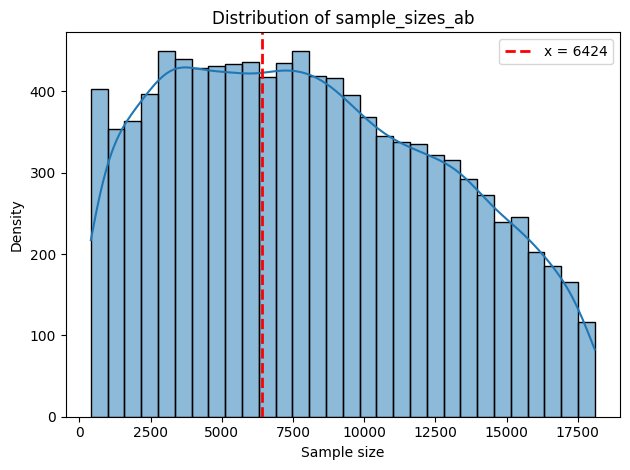

In [484]:
sample_sizes_bf=np.array(probs_bf['sample_sizes_ab'])
mean_sample =np.mean(sample_sizes_bf)
lower_samples = (sample_sizes_bf < 6424).mean()
print(f' mean sample size: {mean_sample:0.2f}, lower_samples_share: {lower_samples:0.2f}')

sns.histplot(probs_bf['sample_sizes_ab'], bins=30, kde=True)
plt.title("Distribution of sample_sizes_ab")
plt.xlabel("Sample size")
plt.ylabel("Density")
plt.axvline(x=6424, color='red', linestyle='--', linewidth=2, label='x = 6424')
plt.legend()
plt.tight_layout()
plt.show()

#### Таким образом:  
Метод Байесовского сравнения гипотез (BF):  

**1.** Позволяет оценить, насколько данные лучше объясняются H₁, чем H₀  
**2.** Является более строгим и требует более крупных выборок  
**3.** Позволяет заметно снизить ошибку 1 рода, не теряя в мощности  
**4.** На нашем примере:  
 **4.1** Для достижения мощности в **88%** потребовалась выборка в **2.8** раза больше,  
 **4.2** Средний размер выборки составил **8095**, что на **26%** больше чем в двух других методах,  
 **4.3** в **42%** экспериментов удалось сократить время теста по сравнению с двумя другими методами.

### Вывод:

**1. Частотный метод**  - простой и универсальный. Мы не проверяем H₀ напрямую, мы оцениваем, насколько данные экстремальны, если она верна.
    Подглядывать нельзя, т.к. ошибка 1 рода при этом не контролируется  
**2. Байесовский анализ параметров (pB > pA)** - нечто среднее между "тру байесовским" и частотным подходами, 
   что-то вроде байесовской реализации частотного метода. Мы не проверяем H₀ напрямую, мы предполагаем что разница между группами есть
   и оцениваем направление и силу этой разницы. Подглядывать нельзя, т.к. ошибка 1 рода при этом не контролируется  
**3. Байесовское сравнение гипотез (BF)** - мы оцениваем правдоподобие самих моделей, определяя, что лучше объясняет данные - H₀ или H₁
    Более сложный в сэтапе и вычислениях, более строгий, требует бОльших выборок, заметно снижает вероятность ошибки 1 рода,
     позволяет подглядывать, но не гарантирует сокращения времени на тест. 